# Precipitation accumulation with advection interpolation

In this notebook we show how to apply advection-based temporal interpolation to improve the accuracy of estimated precipitation accumulations.

In [ ]:
import numpy as np
from pysteps.utils import transformation
from pysteps.datasets import load_dataset

from pysteps.utils.dimension import clip_domain

# Use the original FMI dataset at the 1 km resolution
precip, metadata, timestep = load_dataset('fmi')

# Pick one-hour time series between 14:45 and 15:45 UTC on 28th September 2016
precip_hour = precip[:13]
metadata_hour = metadata.copy()
metadata_hour["timestamps"] = metadata_hour["timestamps"][:13]

# Clip the domain to contain the southern Finland
precip_clipped, metadata_clipped = clip_domain(
    precip_hour,
    metadata,
    extent=(100000, 600000, 120000, 650000)
)

# First compute accumulated precipitation directly from the observations without
# temporal interpolation. This is done by assuming that each instantaneous
# precipitation rate represent the mean value during a 5-minute interval.
precip_accum_nointerp = np.mean(np.stack(np.array(precip_clipped)), axis=0)

# Then proceed with computation of accumulated precipitation from temporally
# interpolated fields
from scipy.ndimage import map_coordinates
from pysteps import motion

# Log-transform to dB units before applying the optical flow
precip_dbr, metadata_dbr = transformation.dB_transform(
    precip_clipped,
    metadata_clipped,
    threshold=0.1,
    zerovalue=-15.0
)

# Estimate the motion field by using the Lucas-Kanade method with 6 time steps
# (30 minutes)
oflow = motion.get_method("LK")
motion_field = oflow(precip_dbr[-6:], verbose=False)

# Our observation time step is 5 minutes
obs_timestep = 5
# The chosen time step between the interpolated fields is 0.25 minutes (15 seconds)
interp_timestep = 0.25

# Here we use scipy.ndimage.map_coordinates. This requires the x- and y-coordinates
# of our grid.
x, y = np.meshgrid(
    np.arange(precip_clipped[0].shape[1], dtype=float),
    np.arange(precip_clipped[0].shape[0], dtype=float)
)

# Define a function for advection-based temporal interpolation. For two given
# precipitation fields, it returns the interpolated time frames between them.
# The endpoints of the interval are not included.
def interpolate(precip1, precip2):
    out = []

    for t in np.arange(interp_timestep, obs_timestep, interp_timestep):
        # Extrapolate the first precipitation field forward by time t / obs_timestep
        coords1 = (y - t / obs_timestep * motion_field[1],
                   x - t / obs_timestep * motion_field[0])
        # Here we use interpolation order 1. Alternatively, we could use
        # extrapolation.semilagrangian.extrapolate here to take advantage of
        # the more advanced functionality.
        precip1_warped = map_coordinates(precip1, coords1, order=0)

        # Extrapolate the second precipitation field forward by time
        # (obs_timestep - t) / obs_timestep
        coords2 = (y + (obs_timestep - t) / obs_timestep * motion_field[1],
                   x + (obs_timestep - t) / obs_timestep * motion_field[0])
        precip2_warped = map_coordinates(precip2, coords2, order=0)

        # Compute interpolated value from precip1 and precip2 that are
        # extrapolated to the same time
        out.append((obs_timestep - t) / obs_timestep * precip1_warped +
                   t / obs_timestep * precip2_warped)

    return out

# Finally compute accumulated precipitation from the interpolated sequence.
# First include the observation time steps that are not interpolated.
precip_accum_interp = np.sum(np.stack(np.array(precip_clipped)), axis=0)
n = len(precip_clipped)
for i in range(len(precip_clipped))[:-1]:
    precip_interp = interpolate(precip_clipped[i], precip_clipped[i+1])
    precip_accum_interp += np.sum(np.stack(np.array(precip_interp)), axis=0)
    n += len(precip_interp)
precip_accum_interp /= n

Pysteps configuration file found at: /home/ritvanen/.pysteps/pystepsrc



Let's then plot the hourly accumulations computed without and with temporal interpolation (time steps 5 minutes and 15 seconds, respectively). This comparison clearly shows that the latter produces a smooth field, whereas the former has the jagged appearance. This is because of the limited time resolution, which makes impossible to capture the motion of precipitation between the time steps.

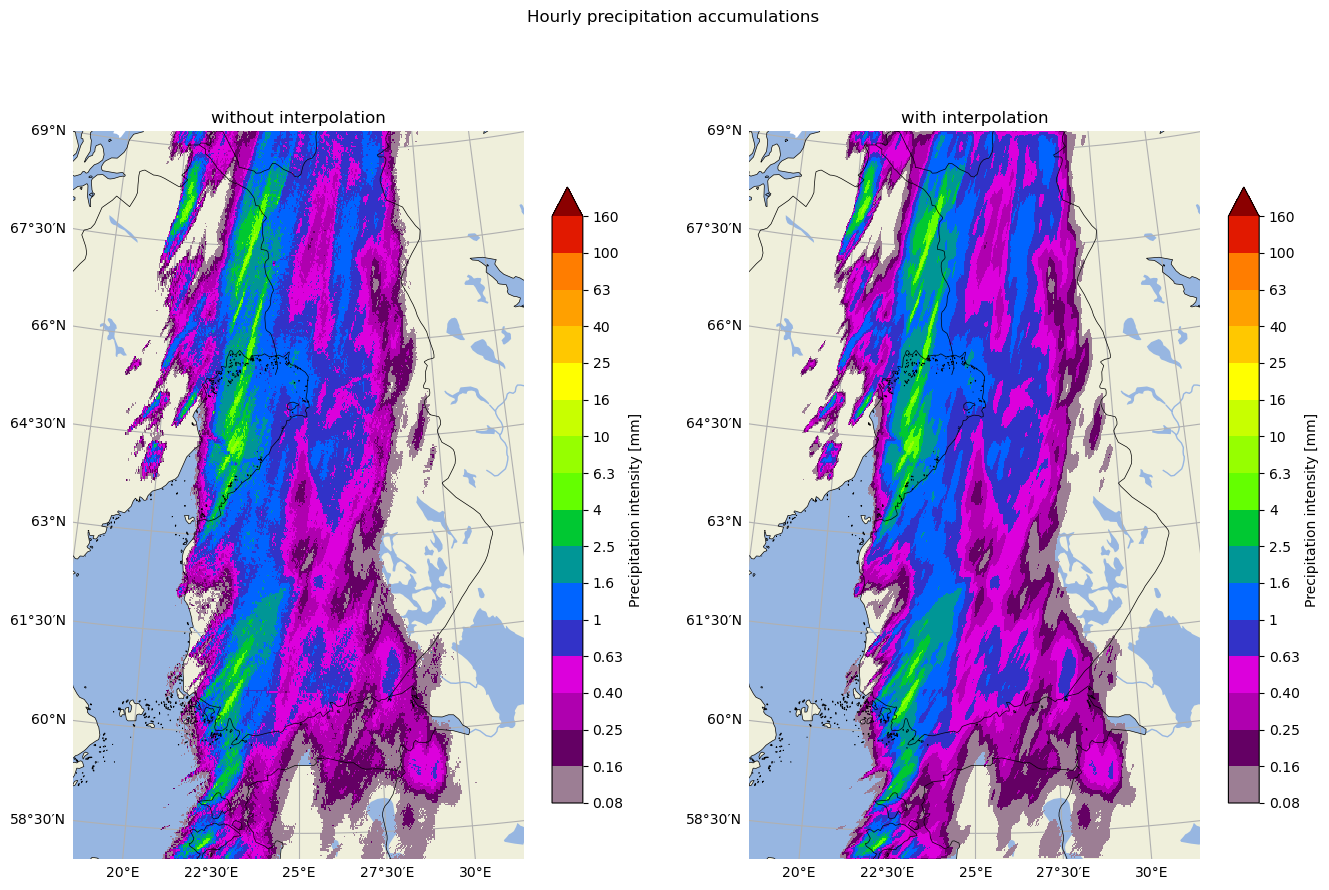

In [2]:
from matplotlib import pyplot as plt
from pysteps.visualization import plot_precip_field

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(121); ax.axis("off")
plot_precip_field(
    precip_accum_nointerp,
    geodata=metadata_hour,
    map_kwargs={"drawlonlatlines": True},
    units="mm",
    ax=ax,
)
plt.title("without interpolation")

ax = fig.add_subplot(122); ax.axis("off")

plot_precip_field(
    precip_accum_interp,
    geodata=metadata_hour,
    map_kwargs={"drawlonlatlines": True},
    units="mm",
    ax=ax,
)
plt.title("with interpolation")

plt.suptitle("Hourly precipitation accumulations")
plt.show()